# Imports

In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path =  [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages',
            '../']
sys.prefix = '/home/joaom/.conda/envs/norm_env'

# from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

In [2]:
from src import utils
from datetime import datetime
conn = utils.connect_athena(path='../configs/athena.yaml')

### Get data

In [305]:
df = pd.read_sql_query(
         "select * from "
        f"spd_sdv_waze_corona.dev_cities_country_cities_hourly_index ", conn)

In [5]:
df.head()

,last_updated_utc,timezone,timestamp_local,timestamp,region_slug,grid_id,month,day,hour,dow,tci,expected_2020,tci_perc_change
0,2020-05-19 15:15:10.151,America/Lima,2020-04-16 11:00:00,2020-04-16 16:00:00,country_brazil,1504976.0,4,16,16,4,11633.000000,35054.169248,-66.814219
1,2020-05-19 15:15:10.151,America/Lima,2020-04-02 11:00:00,2020-04-02 16:00:00,country_brazil,1504976.0,4,2,16,4,10717.000000,35054.169248,-69.427317
2,2020-05-19 15:15:10.151,America/Lima,2020-04-09 11:00:00,2020-04-09 16:00:00,country_brazil,1504976.0,4,9,16,4,64923.184738,35054.169248,85.208168
3,2020-05-19 15:15:10.151,America/Lima,2020-03-12 11:00:00,2020-03-12 16:00:00,country_brazil,1504976.0,3,12,16,4,47487.000000,35054.169248,35.467481
4,2020-05-19 15:15:10.151,America/Lima,2020-05-07 11:00:00,2020-05-07 16:00:00,country_brazil,1504976.0,5,7,16,4,22203.000000,35054.169248,-36.660887


In [273]:
cities = pd.read_csv('../data/support_tables/all_cities/brazil_cities.csv', sep='|')

In [277]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5567 entries, 0 to 5566
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   code_muni     5567 non-null   float64
 1   name_muni     5567 non-null   object 
 2   code_state    5567 non-null   int64  
 3   abbrev_state  5567 non-null   object 
 4   geometry      5567 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 217.6+ KB


In [274]:
cities

,code_muni,name_muni,code_state,abbrev_state,geometry
0,1100015.0,Alta Floresta D'oeste,11,RO,POLYGON ((-62.2461999928511 -11.90149149134201...
1,1100023.0,Ariquemes,11,RO,POLYGON ((-63.13712041193418 -9.78412882823799...
2,1100031.0,Cabixi,11,RO,POLYGON ((-60.52407976507511 -13.3213725299966...
3,1100049.0,Cacoal,11,RO,POLYGON ((-61.42678756392499 -11.1137603129151...
4,1100056.0,Cerejeiras,11,RO,POLYGON ((-61.41347403956169 -13.2341685497038...
...,...,...,...,...,...
5562,5222005.0,Vianópolis,52,GO,POLYGON ((-48.54163788190278 -16.7412615363262...
5563,5222054.0,Vicentinópolis,52,GO,POLYGON ((-49.9071346412557 -17.61460280169521...
5564,5222203.0,Vila Boa,52,GO,POLYGON ((-46.97635062757958 -14.9311235922576...
5565,5222302.0,Vila Propício,52,GO,POLYGON ((-48.86700312843647 -15.0973469055289...


### Time consistency

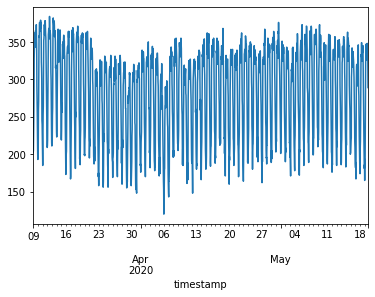

In [317]:
df.groupby('timestamp').count()['grid_id'].plot()

### Number of cities with data per day

In [285]:
daily = df.groupby(['grid_id', 'month', 'day']).apply(lambda x: (x['tci'].sum() / x['expected_2020'].sum() - 1) * 100)

In [286]:
daily = daily.to_frame().reset_index()

In [287]:
daily['date'] = daily.apply(lambda x: pd.Timestamp(year=2020, month=x['month'], day=x['day']),1)

In [270]:
len((daily.pivot_table(columns='date', index='grid_id', values=0).dropna()).index)

372

### Number of cities with data per hour

In [242]:
hourly_cities = df.pivot_table(columns='timestamp_local', index='grid_id', values='tci').dropna().index

In [244]:
len(hourly_cities)

40

## OSM Coverage

In [322]:
import osm_road_length

In [288]:
daily['grid_id'] = daily['grid_id'].astype(float)
daily = daily.merge(cities, left_on='grid_id', right_on='code_muni')

In [292]:
non_null = daily.pivot_table(columns='date', index='name_muni', values=0).dropna().index

In [297]:
daily = daily[daily['name_muni'].isin(non_null)]

In [335]:
from shapely import wkt
def _get_length(x, config):

    lengths = osm_road_length.get(wkt.loads(x))
    lengths = lengths[lengths.index.isin(config["accepted_osm_keys"])]
    return lengths["length"].sum()

In [330]:
daily_unique = daily.drop_duplicates(subset=['grid_id'])[[ 'grid_id', 'name_muni', 'abbrev_state', 'geometry']]

In [336]:
daily_unique['osm_length'] = daily_unique['geometry'].apply(lambda x: _get_length(x, config))

WARNING|%|s|,| |r|e|t|r|y|i|n|g| |i|n| |%|s| |s|e|c|o|n|d|s|.|.|.
WARNING|%|s|,| |r|e|t|r|y|i|n|g| |i|n| |%|s| |s|e|c|o|n|d|s|.|.|.
WARNING|%|s|,| |r|e|t|r|y|i|n|g| |i|n| |%|s| |s|e|c|o|n|d|s|.|.|.


In [337]:
daily_unique

,grid_id,name_muni,abbrev_state,geometry,osm_length
0,1100023.0,Ariquemes,RO,POLYGON ((-63.13712041193418 -9.78412882823799...,2180756.625
48,1100049.0,Cacoal,RO,POLYGON ((-61.42678756392499 -11.1137603129151...,2045858.019
169,1100122.0,Ji-Paraná,RO,POLYGON ((-61.66205501414029 -9.71251582738121...,2007071.028
237,1100155.0,Ouro Preto Do Oeste,RO,POLYGON ((-62.10052368859817 -10.6591578074697...,939627.907
285,1100205.0,Porto Velho,RO,POLYGON ((-63.93601297670062 -8.59285766835945...,7161684.769
...,...,...,...,...,...
22194,5218607.0,Rialma,GO,POLYGON ((-49.57060706750868 -15.2910778684069...,248202.459
22242,5218805.0,Rio Verde,GO,POLYGON ((-50.97293540699259 -17.3203462782514...,3606468.859
22290,5220009.0,São João D'aliança,GO,POLYGON ((-47.4438708628694 -14.14918297779359...,677644.126
22338,5220504.0,Serranópolis,GO,POLYGON ((-52.34036521719129 -17.8447170492438...,703811.589


## CV

In [407]:
cv = pd.read_sql_query("""select
	grid_id,
	avg(tci) as daily_mean,
	stddev_pop(tci) as daily_std,
	stddev_pop(tci) / avg(tci) daily_coef_var
from (
	select 
		grid_id, 
		sum(tci) as tci
	from (select * from spd_sdv_waze_corona.dev_cities_country_cities_2019)
	group by grid_id,
			DAY(date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %d'))
)
group by grid_id""", conn)

In [413]:
cv['grid_id'] = cv['grid_id'].astype(float)

In [415]:
daily_unique = daily_unique.merge(cv, on='grid_id')

## CV x OSM Coverage

In [418]:
import plotly.express as px

In [419]:
daily_unique.head(1)

,grid_id,name_muni,abbrev_state,geometry,osm_length,daily_mean,daily_std,daily_coef_var
0,1100023.0,Ariquemes,RO,POLYGON ((-63.13712041193418 -9.78412882823799...,2180756.625,138957.36376,74205.192293,0.534014


In [422]:
daily_unique['osm_index'] = daily_unique['daily_mean'] / daily_unique['osm_length']

In [426]:
fig = px.scatter(daily_unique,
            y="daily_coef_var", x="osm_index", 
            hover_name="name_muni", template='plotly_white', title='Daily CV by OSM Proportion for Brazilian Municipalities',
           log_x=True)
fig.update_yaxes(title_text='Daily CV (m)')
fig.update_xaxes(title_text='OSM Proportion (m)')

fig.show()

In [428]:
daily_unique.query('osm_index > 0.1').query('daily_coef_var < 0.5')

,grid_id,name_muni,abbrev_state,geometry,osm_length,daily_mean,daily_std,daily_coef_var,osm_index
1,1100049.0,Cacoal,RO,POLYGON ((-61.42678756392499 -11.1137603129151...,2045858.019,2.106844e+05,7.703682e+04,0.365650,0.102981
2,1100122.0,Ji-Paraná,RO,POLYGON ((-61.66205501414029 -9.71251582738121...,2007071.028,4.640813e+05,2.132157e+05,0.459436,0.231223
3,1100155.0,Ouro Preto Do Oeste,RO,POLYGON ((-62.10052368859817 -10.6591578074697...,939627.907,4.640813e+05,2.132157e+05,0.459436,0.493899
4,1100205.0,Porto Velho,RO,POLYGON ((-63.93601297670062 -8.59285766835945...,7161684.769,2.828659e+06,1.246203e+06,0.440563,0.394971
6,1100502.0,Novo Horizonte Do Oeste,RO,POLYGON ((-62.01649793908136 -11.5003031270785...,374026.504,1.378217e+05,5.860885e+04,0.425251,0.368481
...,...,...,...,...,...,...,...,...,...
365,5217401.0,Pires Do Rio,GO,POLYGON ((-48.44501634238009 -17.2156432637813...,510632.605,1.867000e+06,6.911871e+05,0.370213,3.656248
366,5217708.0,Pontalina,GO,POLYGON ((-49.63279757771719 -17.4400909862035...,488354.225,3.542512e+06,1.171418e+06,0.330674,7.253981
367,5218607.0,Rialma,GO,POLYGON ((-49.57060706750868 -15.2910778684069...,248202.459,1.888418e+06,6.069078e+05,0.321384,7.608377
368,5218805.0,Rio Verde,GO,POLYGON ((-50.97293540699259 -17.3203462782514...,3606468.859,3.210629e+06,1.105523e+06,0.344332,0.890242


In [57]:
daily[0].values[daily[0].values > 50] = 50

In [59]:
plot_df = daily.pivot_table(columns='date', index='grid_id', values=0).dropna()

In [60]:
def _df_to_plotly(df):
    return {'z': df.values.tolist(),
            'x': df.columns.tolist(),
            'y': df.index.tolist()}

In [62]:
fig = go.Figure(data=go.Heatmap(
    _df_to_plotly(plot_df),
    colorscale='temps'
))

In [63]:
fig.show()

In [136]:
def sort_index(by, df):
    if by == 'mean':
        return df.reindex(df.mean(1).sort_values().index)
    elif by == 'median':
        return df.reindex(df.mean(1).sort_values().index)
    elif by == 'max':
        return df.reindex(df.max(1).sort_values().index)
    elif by == 'min':
        return df.reindex(df.min(1).sort_values().index)
    elif by == 'last-max':
        return df.reindex(df.iloc[:, -1].sort_values().index)
    elif by == 'last-min':
        return df.reindex(df.iloc[:, -1].sort_values(ascending=False).index)

In [122]:
weekly = pd.read_csv('http://tiny.cc/idb-traffic-weekly')

In [123]:
countries = weekly[weekly['region_type'] == 'country']
to_plot = countries.pivot_table(columns='week_number', index='region_name', values='tcp').iloc[:, :-1]
to_plot = sort_index('mean', to_plot)

fig = go.Figure(data=go.Heatmap(
    _df_to_plotly(to_plot),
    colorscale='temps'
))

fig.update_layout(
    title='TCP Percentage Variation per Week for LAC countries (Sorted by Mean)',
    xaxis=dict(title='Week Number'))

fig.show()

In [141]:
to_plot.idxmin(axis=1)

region_name
Amapa                  13
Amazonas               16
Rio De Janeiro         13
Acre                   13
Para                   13
Distrito Federal       14
Piaui                  13
Ceara                  13
Maranhao               13
Espirito Santo         13
Pernambuco             13
Sao Paulo              13
Rondonia               13
Alagoas                13
Sergipe                13
Paraiba                13
Roraima                13
Rio Grande Do Norte    13
Santa Catarina         13
Bahia                  13
Minas Gerais           13
Goias                  14
Rio Grande Do Sul      13
Parana                 13
Mato Grosso Do Sul     13
Mato Grosso            13
Tocantins              15
dtype: int64

In [145]:
countries.head(1)

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,week_number,min_month,min_day,max_month,max_day,ratio_20,tcp,Unnamed: 16
55,2020-05-19 10:47:16.149000,br_states_amazonas,Amazonas,Brazil,BR,BR,state,NaN,NaN,21,5,18,5,18,0.03725,-96.275042,NaN


In [147]:
countries['week_name'] = countries.apply(lambda x: f"{x['min_day']}/{x['min_month']} to {x['max_day']}/{x['max_month']}", 1)
week_dict = countries.set_index( 'week_number')['week_name'].to_dict()

In [152]:
week_dict = countries.set_index( 'week_number')['week_name'].to_dict()

In [429]:
countries = weekly[weekly['region_type'] == 'state']
to_plot = countries.pivot_table(columns='week_number', index='region_name', values='tcp').iloc[:, :-1]
to_plot = sort_index('last-max', to_plot)
to_plot = to_plot.rename(columns=week_dict)

fig = go.Figure(data=go.Heatmap(
    _df_to_plotly(to_plot),
    colorscale='temps'
))

fig.update_layout(
    title=
        iplottitle('TCI Percentage Change ', 60),
    height=700
)

# fig.add_annotation(text='Semana Referência: 02/03 - 08/03 | Dados: Waze',
#                   x=-0, y=100, showarrow=False, yanchor='top'
#                   )

fig.show()

# Comunas Chile

- weekly CV
- table with weekly CV and OSM
- heatmap with selected and all
- daily heatmap
- daily /wo weekends

In [652]:
OUTPUT_PATH = Path('../data/output/chile-comunas')

## Load Weekly Data

In [659]:
weekly = pd.read_sql_query(
         "select * from "
        f"spd_sdv_waze_corona.dev_cities_country_cities_weekly_index "
        "where region_slug = 'country_chile'"
    , conn)

## Load Daily Data

In [660]:
daily = pd.read_sql_query(
         "select * from "
        f"spd_sdv_waze_corona.dev_cities_country_cities_daily_index "
        "where region_slug = 'country_chile'"
    , conn)

## Load Weekly CV

In [617]:
weekly_cv = pd.read_sql_query("""
select
	grid_id,
	avg(tci) as weekly_mean,
	stddev_pop(tci) as weekly_std,
	stddev_pop(tci) / avg(tci) weekly_coef_var
from (
	select
		grid_id,
		week,
		avg(tci) tci
	from (
		select 
			grid_id, 
			WEEK(date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %d')) week,
			sum(tci) as tci
		from (select * from spd_sdv_waze_corona.dev_cities_country_cities_2019)
		group by grid_id,
				WEEK(date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %d')),
				day(date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %d'))
	)
	group by grid_id, week
	having count(*) = 7
	)
group by grid_id
""", conn).set_index('grid_id')

## Load Daily CV

In [618]:
cv = pd.read_sql_query("""
select
	grid_id,
	avg(tci) as daily_mean,
	stddev_pop(tci) as daily_std,
	stddev_pop(tci) / avg(tci) daily_coef_var
from (
	select 
		grid_id, 
		sum(tci) as tci
	from (select * from spd_sdv_waze_corona.dev_cities_country_cities_2019)
	group by grid_id,
			DAY(date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %d'))
)
group by grid_id
""", conn).set_index('grid_id')

## Calculate OSM Length

In [ ]:
res = pd.read_sql_query(
         "select id grid_id, wkt from "
        f"spd_sdv_waze_corona.dev_cities_country_resolutions "
        "where region_slug = 'country_chile' and resolution = 10"
    , conn).set_index('grid_id')
res['osm_length'] = res['wkt'].apply(lambda x: _get_length(x, config))

## Unify Unique

In [629]:
unique = pd.concat([cv, weekly_cv, res], 1)

In [630]:
unique['osm_index'] = unique['daily_mean'] / unique['osm_length']

## Weekly Plots

### Prepare 

In [661]:
weekly['week_name'] = weekly.apply(lambda x: f"{x['min_day']}/{x['min_month']} to {x['max_day']}/{x['max_month']}", 1)
week_dict = weekly.set_index( 'week_number')['week_name'].to_dict()

### Heatmap All Comunas

In [701]:
to_plot = weekly.query('tci_perc_change < 100').pivot_table(columns='week_number', index='grid_id', values='tci_perc_change').iloc[:, :-1]
# to_plot = to_plot[to_plot.index.isin(comunas)]
to_plot = sort_index('last-max', to_plot)
to_plot = to_plot.rename(columns=week_dict)

fig = go.Figure(data=go.Heatmap(
    _df_to_plotly(to_plot),
    colorscale='temps'
))

fig.update_layout(
    title= 
        iplottitle('TCI Percentage Change per Week For Chilean Comunas (No Filter)', 80),
    height=1100
)
fig.write_html(open(OUTPUT_PATH / 'heatmap_weekly.html', 'w'))
fig.show()

### Heatmap Filtered

In [700]:
comunas = unique.query('weekly_coef_var < 0.5').query('osm_index > 0.1').index

to_plot = weekly.pivot_table(columns='week_number', index='grid_id', values='tci_perc_change').iloc[:, :-1]
to_plot = to_plot[to_plot.index.isin(comunas)]
to_plot = sort_index('last-max', to_plot)
to_plot = to_plot.rename(columns=week_dict)

fig = go.Figure(data=go.Heatmap(
    _df_to_plotly(to_plot),
    colorscale='temps'
))

fig.update_layout(
    title= 
        iplottitle('TCI Percentage Change per Week For Chilean Comunas (Filtered)', 80),
    height=1100
)
fig.write_html(open(OUTPUT_PATH / 'heatmap_weekly_filtered.html', 'w'))
fig.show()

### Write table

In [656]:
pd.concat([to_plot, unique], 1).reset_index().rename(columns={'index': 'comuna'}).to_csv(OUTPUT_PATH / 'weekly-table.csv')

## Daily Plots

In [665]:
daily.head(1)

,region_slug,grid_id,month,day,dow,tci,expected_2020,tci_perc_change
0,country_chile,CURACAVI,5,12,2,180033.44723,809597.085834,-77.762587


In [668]:
daily['date'] = daily.apply(lambda x: pd.Timestamp(year=2020, month=x['month'], day=x['day']), 1)

### Heatmap All Comunas

In [699]:
to_plot = daily.query('tci_perc_change < 100').pivot_table(columns='date', index='grid_id', values='tci_perc_change').iloc[:, :-1]
to_plot = sort_index('last-max', to_plot)

fig = go.Figure(data=go.Heatmap(
    _df_to_plotly(to_plot),
    colorscale='temps'
))

fig.update_layout(
    title= 
        iplottitle('TCI Percentage Change per Day For Chilean Comunas (No Filter)', 80),
    height=1100
)
fig.write_html(open(OUTPUT_PATH / 'heatmap_daily.html', 'w'))
fig.show()

In [688]:
(pd.concat([to_plot, unique], 1)
 .reset_index()
 .rename(columns={'index': 'comuna'})
 .to_csv(OUTPUT_PATH / 'daily-table.csv')
)

### Heatmap Filtered

In [698]:
comunas = unique.query('daily_coef_var < 0.6').query('osm_index > 0.1').index

to_plot = daily.query('tci_perc_change < 100').pivot_table(columns='date', index='grid_id', values='tci_perc_change').iloc[:, :-1]
to_plot = to_plot[to_plot.index.isin(comunas)]
to_plot = sort_index('last-max', to_plot)

fig = go.Figure(data=go.Heatmap(
    _df_to_plotly(to_plot),
    colorscale='temps'
))

fig.update_layout(
    title= 
        iplottitle('TCI Percentage Change per Day For Chilean Comunas (Filtered Daily CV < 0.6)', 50),
    height=1100
)

fig.write_html(open(OUTPUT_PATH / 'heatmap_daily_filtered.html', 'w'))
fig.show()

### Heatmap Filtered no Weekends

In [691]:
comunas = unique.query('daily_coef_var < 0.6').query('osm_index > 0.1').index

to_plot = daily[~daily['dow'].isin([6,7])].query('tci_perc_change < 100').pivot_table(columns='date', index='grid_id', values='tci_perc_change').iloc[:, :-1]
to_plot = to_plot[to_plot.index.isin(comunas)]
to_plot = sort_index('last-max', to_plot)

fig = go.Figure(data=go.Heatmap(
    _df_to_plotly(to_plot),
    colorscale='temps'
))

fig.update_layout(
    title= 
        iplottitle('TCI Percentage Change per Day For Chilean Comunas (Filtered Daily CV < 0.6 & no Weekends)', 50),
    height=1100
)

fig.write_html(open(OUTPUT_PATH / 'heatmap_daily_filtered_noweekends.html', 'w'))
fig.show()

In [697]:
fig.write_json(open(OUTPUT_PATH / 'heatmap_daily_filtered_noweekends.json', 'w'))

In [600]:
fig = px.scatter(unique,
            y="daily_coef_var", x="osm_index", 
            hover_name="grid_id", template='plotly_white', title='Daily CV by OSM Proportion for Chilean Comunas',
           log_x=True)
fig.update_yaxes(title_text='Daily CV (m)')
fig.update_xaxes(title_text='OSM Proportion')
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0=0.1, x1= 0.1
    ),
    dict(
      type= 'line',
      yref= 'y', y0=0.5, y1=0.5,
      xref= 'paper', x0=0, x1=1
    )
])

fig.show()

# Rest

In [ ]:
countries = weekly[weekly['region_type'] == 'country']
to_plot = countries.pivot_table(columns='week_number', index='region_name', values='tcp').iloc[:, :-1]
to_plot = sort_index('mean', to_plot)

fig = go.Figure(data=go.Heatmap(
    _df_to_plotly(to_plot),
    colorscale='temps'
))

fig.update_layout(
    title='TCP Percentage Variation per Week for LAC countries (Sorted by Mean)',
    xaxis=dict(title='Week Number'))

fig.show()

In [689]:
import sys
sys.path

['/home/joaom/.conda/envs/norm_env/lib/python37.zip',
 '/home/joaom/.conda/envs/norm_env/lib/python3.7',
 '/home/joaom/.conda/envs/norm_env/lib/python3.7/lib-dynload',
 '/home/joaom/.conda/envs/norm_env/lib/python3.7/site-packages',
 '../']

In [ ]:
import sys
sys.path =  [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages',
            '../']
sys.prefix = '/home/joaom/.conda/envs/norm_env'

In [690]:
import psutil

In [159]:
existing_dates = pd.read_sql_query(
    "select distinct region_slug, "
    "date_parse(concat(cast(year as varchar), '-', cast(month as varchar), '-', cast(day as varchar)), '%Y-%m-%d') date "
    f"from spd_sdv_waze_corona.dev_daily_daily",
    conn,
)


In [181]:
from src.runners import partitioned_athena_query as pa

In [182]:
config = yaml.load(open('../configs/config-template.yaml', 'r'))

In [183]:
config.update(
    yaml.load("""
interval:
    start: 2020-03-09
    end: 'today'
    """)
)

In [184]:
dates = pa._all_dates(config)
dates["date"] = dates["timestamp"].apply(lambda x: x.date())
dates = dates.groupby("date").filter(
                    lambda x: len(x) == 24
                )  # O

In [189]:
remaining_dates = existing_dates.groupby("region_slug").apply(
    lambda x: pa._get_remaining_dates(x, dates)
)

remaining_dates["date_slug"] = remaining_dates["date"].apply(
    lambda x: x.strftime(config["daily_aggregation"])
)


In [193]:
remaining_dates = remaining_dates.reset_index()[
                    ["region_slug", "date_slug"]
                ].drop_duplicates()

In [197]:
remaining_dates[remaining_dates['region_slug']=='country_brazil']

,region_slug,date_slug
1273,country_brazil,year2020month03
1289,country_brazil,year2020month05


In [207]:
pa._add_date_slug(data[data['region_slug'] == 'country_brazil'], config)

,country_name,country_iso,region_name,region_type,population,dashboard,timezone,region_shapefile_wkt,rerun,grid,region_slug,osm_length,idb_code,waze_code,country_name_idb_eng,region_shapefile_binary,area,n_days,daily_mean,daily_std,weekly_mean,weekly_std,daily_coef_var,daily_mean_weekend,daily_std_weekend,daily_coef_var_weekend,daily_mean_weekday,daily_std_weekday,daily_coef_var_weekday,daily_osm_ratio,weekend_osm_ratio,weekday_osm_ratio,weekly_osm_ratio,daily_approved,weekly_approved,date_slug,date_filter,from_table
0,Brazil,BR,Brasil,country,212559409,TRUE,America/Lima,"MULTIPOLYGON (((-73.983063 -7.534734,-73.95117...",FALSE,FALSE,country_brazil,2.428959e+09,BR,BR,Brazil,b'\x00\x00\x00\x00\x06\x05\x00\x00\x00\x17\xba...,708.049894,364,3.362800e+08,6.765438e+08,2.353960e+09,4.608878e+09,2.011846,2.562970e+08,5.066863e+08,1.97695,3.682732e+08,7.311095e+08,2.852587,0.138446,0.105517,0.151618,0.138446,False,False,year2020month03,2020030905|2020030906|2020030907|2020030908|20...,spd_sdv_waze_reprocessed.jams_ready
1,Brazil,BR,Brasil,country,212559409,TRUE,America/Lima,"MULTIPOLYGON (((-73.983063 -7.534734,-73.95117...",FALSE,FALSE,country_brazil,2.428959e+09,BR,BR,Brazil,b'\x00\x00\x00\x00\x06\x05\x00\x00\x00\x17\xba...,708.049894,364,3.362800e+08,6.765438e+08,2.353960e+09,4.608878e+09,2.011846,2.562970e+08,5.066863e+08,1.97695,3.682732e+08,7.311095e+08,2.852587,0.138446,0.105517,0.151618,0.138446,False,False,year2020month04,2020040105|2020040106|2020040107|2020040108|20...,"""p-waze-parquet-waze"".""jams"""
2,Brazil,BR,Brasil,country,212559409,TRUE,America/Lima,"MULTIPOLYGON (((-73.983063 -7.534734,-73.95117...",FALSE,FALSE,country_brazil,2.428959e+09,BR,BR,Brazil,b'\x00\x00\x00\x00\x06\x05\x00\x00\x00\x17\xba...,708.049894,364,3.362800e+08,6.765438e+08,2.353960e+09,4.608878e+09,2.011846,2.562970e+08,5.066863e+08,1.97695,3.682732e+08,7.311095e+08,2.852587,0.138446,0.105517,0.151618,0.138446,False,False,year2020month05,2020050105|2020050106|2020050107|2020050108|20...,"""p-waze-parquet-waze"".""jams"""


In [216]:
metadata = data[data['region_slug'] == 'country_brazil']

In [209]:
dates["from_table"] = np.where(
        dates["timestamp"] < pd.to_datetime(config["daily_table"]["break_date"]),
        config["daily_table"]["before"],
        config["daily_table"]["after"],
    )

In [318]:
dates["date_slug"] = dates.apply(
        lambda x: x['timestamp'].strftime(config["daily_aggregation"]) + x['from_table'][-5:-1]
    , 1)

In [319]:
(
        dates.groupby(["date_slug", 'from_table'])
        .apply(lambda x: pa._get_hours(x, metadata))
        .reset_index()
        .drop("level_2", 1)
    )

,date_slug,from_table,date_filter,timezone
0,year2020month03jams,"""p-waze-parquet-waze"".""jams""",2020031505|2020031506|2020031507|2020031508|20...,America/Lima
1,year2020month03read,spd_sdv_waze_reprocessed.jams_ready,2020030905|2020030906|2020030907|2020030908|20...,America/Lima
2,year2020month04jams,"""p-waze-parquet-waze"".""jams""",2020040105|2020040106|2020040107|2020040108|20...,America/Lima
3,year2020month05jams,"""p-waze-parquet-waze"".""jams""",2020050105|2020050106|2020050107|2020050108|20...,America/Lima


In [221]:
dates.groupby(["date_slug"]).apply(lambda x: pa._get_hours(x, metadata))

,,date_filter,from_table,timezone
date_slug,,,,
year2020month03,0,2020030905|2020030906|2020030907|2020030908|20...,spd_sdv_waze_reprocessed.jams_ready,America/Lima
year2020month04,0,2020040105|2020040106|2020040107|2020040108|20...,"""p-waze-parquet-waze"".""jams""",America/Lima
year2020month05,0,2020050105|2020050106|2020050107|2020050108|20...,"""p-waze-parquet-waze"".""jams""",America/Lima


In [382]:
pa._all_dates(config)

,timestamp
0,2020-03-09 00:00:00
1,2020-03-09 01:00:00
2,2020-03-09 02:00:00
3,2020-03-09 03:00:00
4,2020-03-09 04:00:00
...,...
1759,2020-05-21 07:00:00
1760,2020-05-21 08:00:00
1761,2020-05-21 09:00:00
1762,2020-05-21 10:00:00


In [384]:
pa._add_date_slug(metadata, config)

,country_name,country_iso,region_name,region_type,population,dashboard,timezone,region_shapefile_wkt,rerun,grid,region_slug,osm_length,idb_code,waze_code,country_name_idb_eng,region_shapefile_binary,area,n_days,daily_mean,daily_std,weekly_mean,weekly_std,daily_coef_var,daily_mean_weekend,daily_std_weekend,daily_coef_var_weekend,daily_mean_weekday,daily_std_weekday,daily_coef_var_weekday,daily_osm_ratio,weekend_osm_ratio,weekday_osm_ratio,weekly_osm_ratio,daily_approved,weekly_approved,date_slug,from_table,date_filter
0,Brazil,BR,Brasil,country,212559409,TRUE,America/Lima,"MULTIPOLYGON (((-73.983063 -7.534734,-73.95117...",FALSE,FALSE,country_brazil,2.428959e+09,BR,BR,Brazil,b'\x00\x00\x00\x00\x06\x05\x00\x00\x00\x17\xba...,708.049894,364,3.362800e+08,6.765438e+08,2.353960e+09,4.608878e+09,2.011846,2.562970e+08,5.066863e+08,1.97695,3.682732e+08,7.311095e+08,2.852587,0.138446,0.105517,0.151618,0.138446,False,False,year2020month03ams,"""p-waze-parquet-waze"".""jams""",2020031505|2020031506|2020031507|2020031508|20...
1,Brazil,BR,Brasil,country,212559409,TRUE,America/Lima,"MULTIPOLYGON (((-73.983063 -7.534734,-73.95117...",FALSE,FALSE,country_brazil,2.428959e+09,BR,BR,Brazil,b'\x00\x00\x00\x00\x06\x05\x00\x00\x00\x17\xba...,708.049894,364,3.362800e+08,6.765438e+08,2.353960e+09,4.608878e+09,2.011846,2.562970e+08,5.066863e+08,1.97695,3.682732e+08,7.311095e+08,2.852587,0.138446,0.105517,0.151618,0.138446,False,False,year2020month03ead,spd_sdv_waze_reprocessed.jams_ready,2020030905|2020030906|2020030907|2020030908|20...
2,Brazil,BR,Brasil,country,212559409,TRUE,America/Lima,"MULTIPOLYGON (((-73.983063 -7.534734,-73.95117...",FALSE,FALSE,country_brazil,2.428959e+09,BR,BR,Brazil,b'\x00\x00\x00\x00\x06\x05\x00\x00\x00\x17\xba...,708.049894,364,3.362800e+08,6.765438e+08,2.353960e+09,4.608878e+09,2.011846,2.562970e+08,5.066863e+08,1.97695,3.682732e+08,7.311095e+08,2.852587,0.138446,0.105517,0.151618,0.138446,False,False,year2020month04ams,"""p-waze-parquet-waze"".""jams""",2020040105|2020040106|2020040107|2020040108|20...
3,Brazil,BR,Brasil,country,212559409,TRUE,America/Lima,"MULTIPOLYGON (((-73.983063 -7.534734,-73.95117...",FALSE,FALSE,country_brazil,2.428959e+09,BR,BR,Brazil,b'\x00\x00\x00\x00\x06\x05\x00\x00\x00\x17\xba...,708.049894,364,3.362800e+08,6.765438e+08,2.353960e+09,4.608878e+09,2.011846,2.562970e+08,5.066863e+08,1.97695,3.682732e+08,7.311095e+08,2.852587,0.138446,0.105517,0.151618,0.138446,False,False,year2020month05ams,"""p-waze-parquet-waze"".""jams""",2020050105|2020050106|2020050107|2020050108|20...


In [385]:
from src import utils

In [396]:
dates = pd.Series(
    utils.sample_query_weeks(config['full_2019_interval']['start'], config['full_2019_interval']['end'], False),
    name="timestamp",
    ).to_frame()

In [398]:
dates["from_table"] = np.where(
        dates["timestamp"] < pd.to_datetime(config["daily_table"]["break_date"]),
        config["daily_table"]["before"],
        config["daily_table"]["after"],
    )

In [401]:
dates["date_slug"] = dates.apply(
        lambda x: x["timestamp"].strftime('year%Y')
        + x["from_table"][-4:-1],
        1,
    )

In [404]:
dates = (
        dates.groupby(["date_slug", "from_table"])
        .apply(lambda x: pa._get_hours(x, metadata))
        .reset_index()
        .drop("level_2", 1)
    )

In [431]:
pd.read_csv('../data/output/regions/chile_comunas.csv').to_csv('../data/support_tables/all_cities/chile_comunas.csv', sep='|')

In [435]:
pd.read_csv('../data/support_tables/all_cities/brazil_cities.csv', sep='|').rename(
    columns={'code_muni': 'region_name', 'geometry': 'region_shapefile_wkt'}).to_csv(
'../data/support_tables/all_cities/brazil_cities.csv', sep='|')

In [475]:
from src.runners.all_cities import _wkt_to_geojson, _get_cell

In [482]:
config['coarse_resolutions'] = 3
config['job'] = {'region_slug': 'country_chile', 'file': 'chile_comunas.csv'}

In [557]:
(pd.read_csv('../data/support_tables/all_cities/chile_comunas.csv', sep='|')
.set_index("region_name")["region_shapefile_wkt"]
                .apply(lambda x: wkt.loads(x).convex_hull.to_wkt())
                .apply(_wkt_to_geojson)
                .reset_index()
                .groupby("region_name")["region_shapefile_wkt"]
                .apply(
                    lambda x: _get_cell(
                        x, config["coarse_resolutions"], config["coarse_resolutions"], True
                    )
                )
                .reset_index()
                .drop(["level_1", "id_parent"], 1)
                .rename(columns={"region_name": "id", "id": "id_parent"})
                .assign(region_slug='regions', resolution=10))

,id,id_parent,resolution,group,wkt,region_slug
0,ALHUE,83b2c0fffffffff,10,0,"polygon((-71.07216 -34.184196,-71.082056 -34.1...",regions
1,BUIN,83b2c5fffffffff,10,0,"polygon((-70.784712 -33.834626,-70.83195 -33.8...",regions
2,CALERA DE TANGO,83b2c5fffffffff,10,0,"polygon((-70.802465 -33.668412,-70.836348 -33....",regions
3,CERRILLOS,83b2c5fffffffff,10,0,"polygon((-70.706741 -33.53124,-70.726398 -33.5...",regions
4,CERRO NAVIA,83b2c5fffffffff,10,0,"polygon((-70.722406 -33.438934,-70.740902 -33....",regions
5,COLINA,83b2c5fffffffff,10,0,"polygon((-70.63851 -33.342755,-70.643028 -33.3...",regions
6,CONCHALI,83b2c5fffffffff,10,0,"polygon((-70.68186 -33.403,-70.689931 -33.3893...",regions
7,CURACAVI,83b2c5fffffffff,10,0,"polygon((-70.948432 -33.560649,-71.013444 -33....",regions
8,EL BOSQUE,83b2c5fffffffff,10,0,"polygon((-70.663241 -33.585164,-70.676675 -33....",regions
9,EL MONTE,83b2c0fffffffff,10,0,"polygon((-71.068217 -33.721823,-71.07808 -33.7...",regions


In [500]:
_get_cell(
            a, config["coarse_resolutions"], config["coarse_resolutions"]
        )

TypeError: 'builtin_function_or_method' object is not subscriptable

In [516]:
h3.polyfill(a[0], 3, True)

set()

In [527]:
h3.geo_to_h3(
    **dict(zip(('lat', 'lng'), a[0]['coordinates'][0][0])), res=3
)

'83ee19fffffffff'

In [529]:
h3.h3_to_geo_boundary('83ee19fffffffff')

[[-72.07219626255657, -31.751428107639782],
 [-71.53238917619703, -30.426367615704343],
 [-70.90604116111153, -31.246463586611302],
 [-70.80448100653209, -33.29819848532846],
 [-71.32310583443733, -34.652225092855524],
 [-71.96416921037223, -33.93062756987335]]

In [508]:
a = (pd.read_csv('../data/support_tables/all_cities/chile_comunas.csv', sep='|')
.set_index("region_name")["region_shapefile_wkt"]
                .apply(lambda x: wkt.loads(x).convex_hull.to_wkt())
                .apply(_wkt_to_geojson)
                .reset_index())['region_shapefile_wkt']